In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from math import ceil
from tqdm.notebook import trange, tqdm
from scipy.spatial import distance
import scipy.stats
%matplotlib inline

# Read features


In [3]:
d_dir = "./data/en-cola/"
subset = "test.csv"
model_path_tr = "./la-tda-models/bert-base-cased-en-cola_32_3e-05_lr_0.01_decay_balanced/"
model_path_nt = "./la-tda-models/bert-base-cased-en-cola_32_3e-05_lr_0.01_decay_balanced_frozen/"

In [4]:
df = pd.read_csv(d_dir + subset, index_col = 0)
pd.set_option('max_colwidth', 400)
y = pd.DataFrame(pd.array(df['label']))
df.sample()

,label,judgement,sentence
code,,,
j_71,0,*,"Tom will smoke the grass, and Reuben has the hash."


In [5]:
subset = subset.split(".")[0]

In [6]:
topological_names = 's_w_e_v_c_b0_b1_m_k'.split('_')
topological_thresholds = [0.025, 0.05, 0.1, 0.25, 0.5, 0.75]
topological_feature_names = [f'{n}_t{t}' for n in topological_names for t in topological_thresholds]

In [7]:
topological_features_tr = np.load(model_path_tr + "features/"+subset.split(".")[0] + '_s_w_e_v_c_b0b1_m_k_lists_array_' + str(len(topological_thresholds)) + '.npy')
topological_features_nt = np.load(model_path_nt + "features/"+subset.split(".")[0] + '_s_w_e_v_c_b0b1_m_k_lists_array_' + str(len(topological_thresholds)) + '.npy')
template_features_tr = np.load(model_path_tr + "features/"+ subset.split(".")[0] + '_template.npy')
template_features_nt = np.load(model_path_nt + "features/"+ subset.split(".")[0] + '_template.npy')
barcode_features_tr = np.load(model_path_tr + "features/"+subset.split(".")[0] +'_ripser.npy')
barcode_features_nt = np.load(model_path_nt + "features/"+ subset.split(".")[0] + '_ripser.npy')

In [8]:
NUM_layers = topological_features_nt.shape[0]
NUM_heads = topological_features_nt.shape[1]
NUM_layers, NUM_heads

(12, 12)

In [9]:
inds=list(range(df.shape[0]))

# Feature-targets correlation


In [10]:
#@title Draw heatmaps function
def draw_heatmaps_trained_nontrained(
                                 sf,
                                 thresholds=[],
                                 vmin=None,
                                 vmax=None,
                                 transpose=False,
                                 stats_name="",
                                 title=None,
                                 annot=None,
                                 annot_color='w',
                                 color_scheme='coolwarm',
                                 figsize=(14,5),
                                 pad=0.5,
                                 ticks=[i for i in range(12)],
                                 ticks_font_size=9,
                                 precision=2,
                                 labels_font_size=10,
                                 annot_font_size=10,
                                 subtitles_font_size=16,
                                 subtitles_pad=12,
                                 enable_grid=False,
                                 zorder=0,
                                 pdf_file=None,
                                 norm = None,
                                 topological = True):
    if vmax is None or vmin is None:
        vmin =  1e10
        vmax = -1e10
        for j in range(len(sf)):
            surfaces = sf[j]
            for array in surfaces.values():
                vmax = max(vmax, max(array.flatten()))
                vmin = min(vmin, min(array.flatten()))
            if not norm:
                vmax = 1
                vmin = -1
    naming_={'non-trained':'Frozen', 'trained': 'Fine-tuned'}
    plots_dim = len(sf)
    if not transpose:
        fig, axs = plt.subplots(len(sf[0].keys()), plots_dim, squeeze=False)
    else:
        fig, axs = plt.subplots(plots_dim, len(sf[0].keys()), squeeze=False)
    fig.set_size_inches(figsize)
    fig.tight_layout(pad=pad)
    for j in range(len(sf)):
        surfaces = sf[j]
        k = 0
        for key in sorted(surfaces.keys()):
            Z = surfaces[key]
            cell_num = (k, j) if not transpose else (j, k)
            if norm:
                cp = axs[cell_num].imshow(Z, interpolation='none', cmap=color_scheme, vmin=vmin, vmax=vmax, norm = norm)
            else:
                cp = axs[cell_num].imshow(Z, interpolation='none', cmap=color_scheme, vmin=vmin, vmax=vmax)
            if labels_font_size > 0:
                # axs[cell_num].set_xlabel('head',  fontsize=subtitles_font_size)
                axs[cell_num].set_ylabel(naming_[key].capitalize() + '\nlayer#', fontsize=subtitles_font_size)
            if k == 0:
                value = ''
                try: 
                    value = thresholds[j]
                except:
                    value = ''
                if subtitles_font_size > 0:
                    axs[cell_num].set_title(value, fontsize=subtitles_font_size, pad=subtitles_pad)
                else:
                    axs[cell_num].set_title(value)
                
            axs[cell_num].set_xticks(ticks)
            axs[cell_num].set_yticks(ticks)
            for tick in axs[cell_num].xaxis.get_major_ticks():
                tick.label.set_fontsize(ticks_font_size)
            for tick in axs[cell_num].yaxis.get_major_ticks():
                tick.label.set_fontsize(ticks_font_size)
            if enable_grid:
                axs[cell_num].xaxis.grid(True, color='black', zorder=zorder)
                axs[cell_num].yaxis.grid(True, color='black', zorder=zorder)
            
            if annot is not None:
                for y in range(Z.shape[0]):
                    for x in range(Z.shape[1]):
                        formatstring = "{:." + str(precision) + "f}"
                        axs[cell_num].text(x,
                                 y,
                                 formatstring.format(annot[j][key][y, x]),
                                 fontsize=annot_font_size, 
                                 color=annot_color, 
                                 horizontalalignment='center',
                                 verticalalignment='center')
            k += 1
    fig.supxlabel('\n\nHead#')
    common_cb = fig.colorbar(cp, ax=axs[:, :])
    common_cb.ax.tick_params(labelsize=subtitles_font_size)
    for ax in axs.flat:
        ax.label_outer()
    args = {}
    if thresholds:
        args = {'x' : 0.4}
        plt.subplots_adjust(top=0.75, bottom=0.1, left=0.07, right=0.81, hspace=0.15, wspace=0.15)
    if topological:
        title = title + '\n\nThresholds' if thresholds else title
    else:
        title = 'features'
    fig.suptitle(title, fontsize=subtitles_font_size, **args)
    
    if pdf_file is not None:
        pdf_file.savefig()
    # plt.show()

In [11]:
#@title Functions for extracting features values
def topological_get_layer_head(features, layer, head):
    df = features[layer,head,:,:,:]
    df = np.moveaxis(df, 0, -1)
    df = np.moveaxis(df, 2,  1)
    nfeat = df.shape[1]
    nthrs = df.shape[2]
    df = df.reshape((df.shape[0], nfeat * nthrs))
    return pd.DataFrame(df, columns=topological_feature_names)

def barcode_get_layer_head(features, layer, head):
    return pd.DataFrame(features[layer,head,:,:], columns=barcode_feature_names)

def template_get_layer_head(features, layer, head):
    df = features[layer,head,:,:]
    return pd.DataFrame(df.T, columns=template_feature_names)
def corr(X):
    """Return an array of correlation coefs between features and targets
    :param X: np.array of the shape(y.shape[0], number of features + 1 (targets))
    :rtype: np.array of corr.coefs
    """
    C = np.corrcoef(X, rowvar=False)
    np.fill_diagonal(C, 0)
    C[np.isnan(C)] = 0
    return C[:,-1]
def stat(X):
    """Return an array of p-values
 
    :param X: np.array of the shape(y.shape[0], number of features + 1 (targets))
    :rtype: np.array of p-values
    """
    y = X['y']
    values_1 = np.argwhere(y.values == 1) # correct sents
    values_0 = np.argwhere(y.values == 0) # incorrect sents
    ps = []
    for col in range(X.shape[1]-1):
        top_values_0 = X.to_numpy()[:, col][values_0]
        top_values_1 = X.to_numpy()[:, col][values_1]
        try:
            _, pval = mannwhitneyu(top_values_0, top_values_1,  alternative = 'two-sided')
            ps.append(pval)
        except:
            # the case of the 1 unique value in the feature values
            # print(f'For the feature {names[col]} all values are the same, layer {layer}, head {head}')
            ps.append(0.9)
    ps = np.array(ps)
    return ps
def get_matrices(features, func, y, names, type_ = corr):
    """Return a matrix filled with correlation coefficients, p-values, or roc auc scores
 
    :param features: np.array of features, of the shape (NUM_layers, NUM_heads)
    :param func: function object for getting features[l, h] out of the features
    :param y: pd.array/np.array of target.values
    :param names: list of features' names
    :param type_: 'corr' or 'stat' or 'auc' - types of coefficients (function's name), 
                    default corr

    :rtype: matrix of the shape (NUM_layers, NUM_heads)
    """
    m = {}
    for name in names:
        if name not in m:
            m[name] = np.zeros((NUM_heads, NUM_layers))
            m[name][:,:] = -10
    function = type_
    for layer in range(NUM_layers):
        for head in range(NUM_heads):
            X = func(features, layer, head)
            X['y'] = y
            X=X.iloc[inds,:].reset_index()
            values = function(X)
            
            for i,name in enumerate(names):
                m[name][layer,head] = values[i]
    max_or_min = False if type_ == stat else True
    show_max_matrices(m, max_or_min)
    return m
def show_max_matrices(mtrs, max_val = True):
    """Print max/min values of matrices and its indices: 
    feature: value  layer head
    """
    arr_p=dict()
    for f in mtrs:
        m = mtrs[f]
        coord = np.argmin(np.abs(m), axis=None)
        if max_val: 
            coord = np.argmax(np.abs(m), axis=None)
        i, j = np.unravel_index(coord, m.shape)
        vmax = m[i,j]
        key_=f"{f}_{i}_{j}"
        arr_p[key_]=vmax
    arr_p = sorted(((v, k) for k, v in arr_p.items()), reverse=not max_val)
    for i in arr_p:
        f,j,k="_".join(i[1].split('_')[:-2]),i[1].split('_')[-2],i[1].split('_')[-1]
        print(f'{f}: {i[0]}  {j} {k}')
    return
def feat_construction(f, t, topological):
    """
    returns a feat

    :param f: feature name if topological
    :param t: threshold
    :param topological: True if topological else False

    :rtype: string of feature with a threshold if topological
    """
    if topological:
        return f"{f}_t{t}"
    else:
        return f"{t}"
def make_comparison_data(m_tr, m_nt, feature, names, topological = False):
    data = []
    ths = []
    t = 0
    def find_feature_val(t_or_f):
        feat = feat_construction(feature, t_or_f, topological)
        data.append({'trained': m_tr[feat], 'non-trained': m_nt[feat]})
        ths.append(t_or_f)
    if topological:
        for _, t in enumerate(topological_thresholds):
            find_feature_val(t)
    else:
        for f in names:
            find_feature_val(f)
    return data, ths

topological_titles = {
    's': 'Connected strong components',
    'w': 'Connected weak components',
    'e': 'Edge number',
    'v': 'Average Vertex Degree',
    'c': 'Simple cycles',
    'b0': 'Betty 0',
    'b1': 'Betty 1',
    "k": "Chordality",
    "m": "Matching #"
}
template_feature_names = [
    'self',
    'beginning',
    'prev',
    'next',
    'comma',
    'dot', 
    'sep']

barcode_feature_names = [
    'h0_s', 
    'h0_e',
    'h0_t_d', 
    'h0_n_d_m_t0.75',
    'h0_n_d_m_t0.5',
    'h0_n_d_l_t0.25',
    'h1_t_b',
    'h1_n_b_m_t0.25',
    'h1_n_b_l_t0.95', 
    'h1_n_b_l_t0.70',  
    'h1_s',
    'h1_e',
    'h1_v',
    'h1_nb'
]
barcode_titles = {
    'h0_s': 'h0, sum of lengths', 
    'h0_e': 'h0, entropy',
    'h0_t_d': 'h0, death time', 
    'h0_n_d_m_t0.75': '#h0, death time > t_0.75',
    'h0_n_d_m_t0.5':'#h0, death time > t_0.5',
    'h0_n_d_l_t0.25':'#h0, death time < t_0.25',
    'h1_t_b':'h1, birth time',
    'h1_n_b_m_t0.25':'#h1, birth time > t_0.25',
    'h1_n_b_l_t0.95':'#h1, birth time < t_0.95', 
    'h1_n_b_l_t0.70':'#h1, birth time < t_0.7',  
    'h1_s':'h1, sum of lengths',
    'h1_e':'h1, entropy',
    'h1_v':'h1, variance of lengths',
    'h1_nb':'number of barcodes in h1' }

In [12]:
print("Fine-tuned model", end='\n\n')
matrices_tr = get_matrices(topological_features_tr, topological_get_layer_head, y.values, names=topological_feature_names)
print("="*6)
print("Model with frozen weights", end='\n\n')
matrices_nt = get_matrices(topological_features_nt, topological_get_layer_head, y, names=topological_feature_names)

Fine-tuned model

v_t0.05: -0.48983871135449214  10 3
k_t0.5: -0.47086217203210917  11 9
v_t0.1: -0.4707893962097253  11 9
c_t0.5: -0.440116404883158  11 9
m_t0.25: -0.41943138551543085  11 9
v_t0.25: -0.40532703300665446  11 9
b1_t0.25: -0.39775421867546124  11 9
b0_t0.5: -0.3931565120416548  10 3
w_t0.5: -0.3931565120416548  10 3
c_t0.75: -0.3698482236642173  10 3
b1_t0.75: -0.36875341207374474  10 3
m_t0.1: -0.3596968055198198  11 9
b1_t0.1: -0.3596484485589206  11 9
k_t0.25: -0.31131348163467026  11 6
e_t0.1: -0.298871194379307  11 9
s_t0.05: -0.2966901321311223  10 7
b0_t0.025: -0.29494365049874893  10 3
m_t0.025: -0.29494365049874893  10 3
e_t0.25: -0.2867413395564104  11 9
c_t0.25: -0.273630132378419  10 3
b1_t0.05: -0.2730289832244542  11 9
b0_t0.25: -0.27007088170803  10 11
w_t0.25: -0.27007088170803  10 11
b0_t0.75: -0.2690309010931159  10 3
w_t0.75: -0.2690309010931159  10 3
s_t0.1: -0.24715883291224122  10 7
m_t0.5: -0.23460230796182996  11 10
e_t0.05: -0.23350697208795726 

<ipython-input-10-c4c635534f26>:73: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(ticks_font_size)
<ipython-input-10-c4c635534f26>:75: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(ticks_font_size)


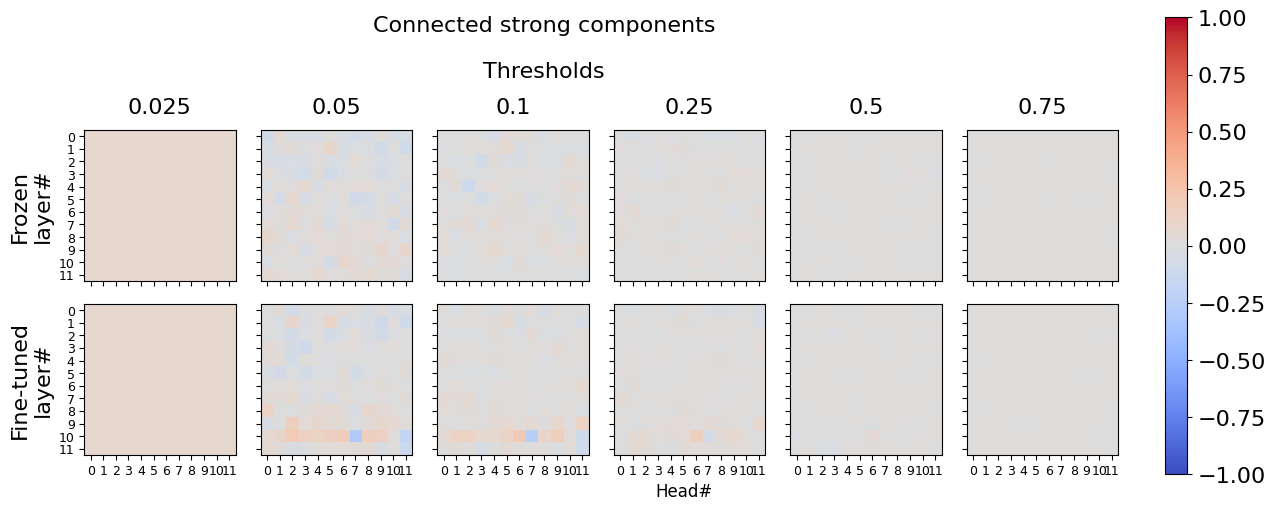

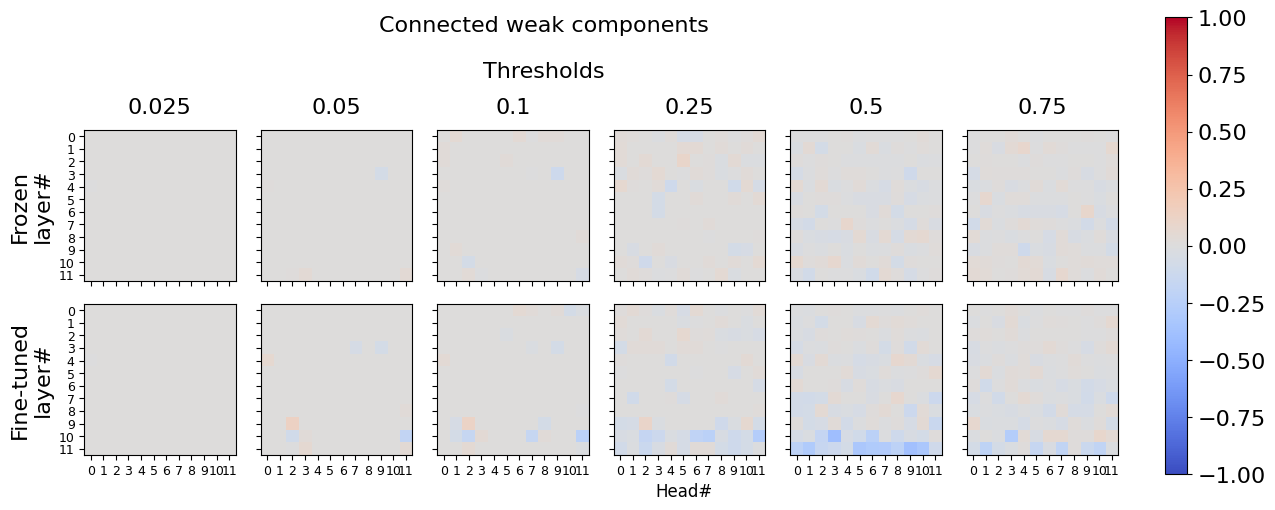

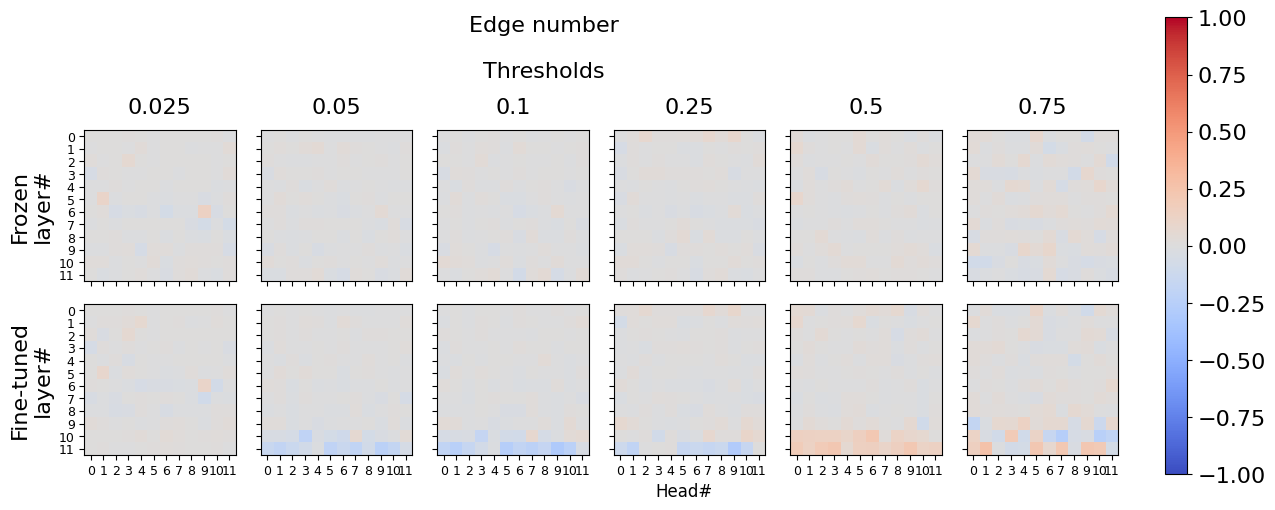

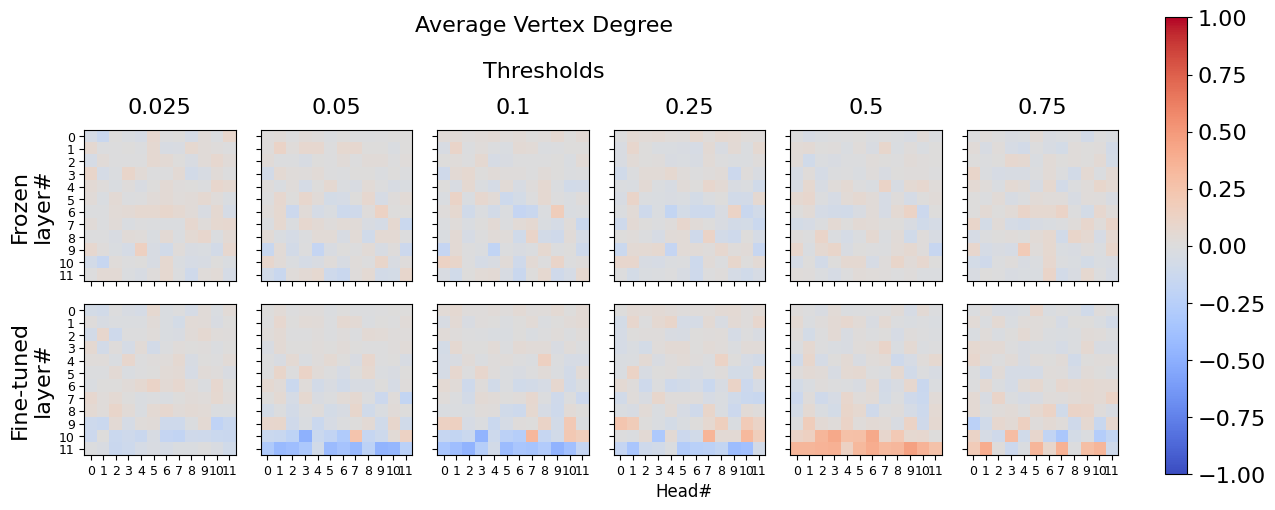

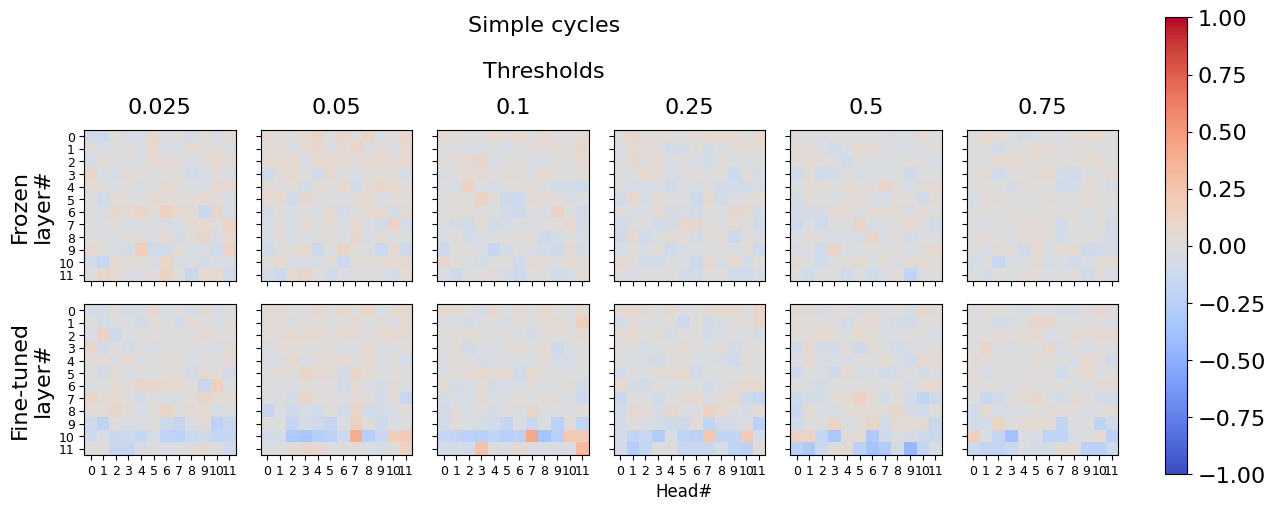

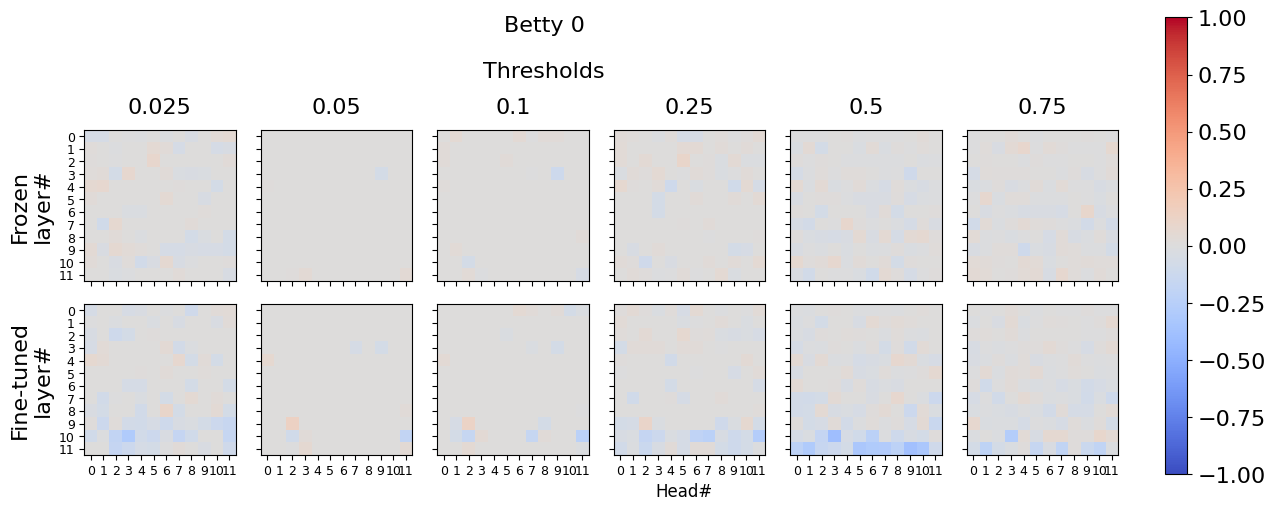

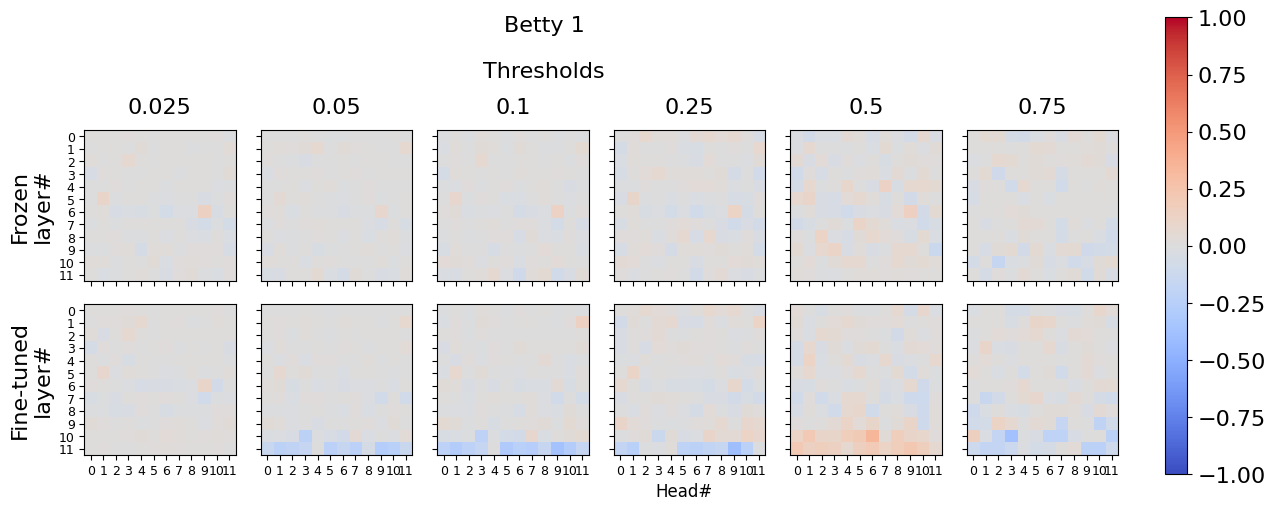

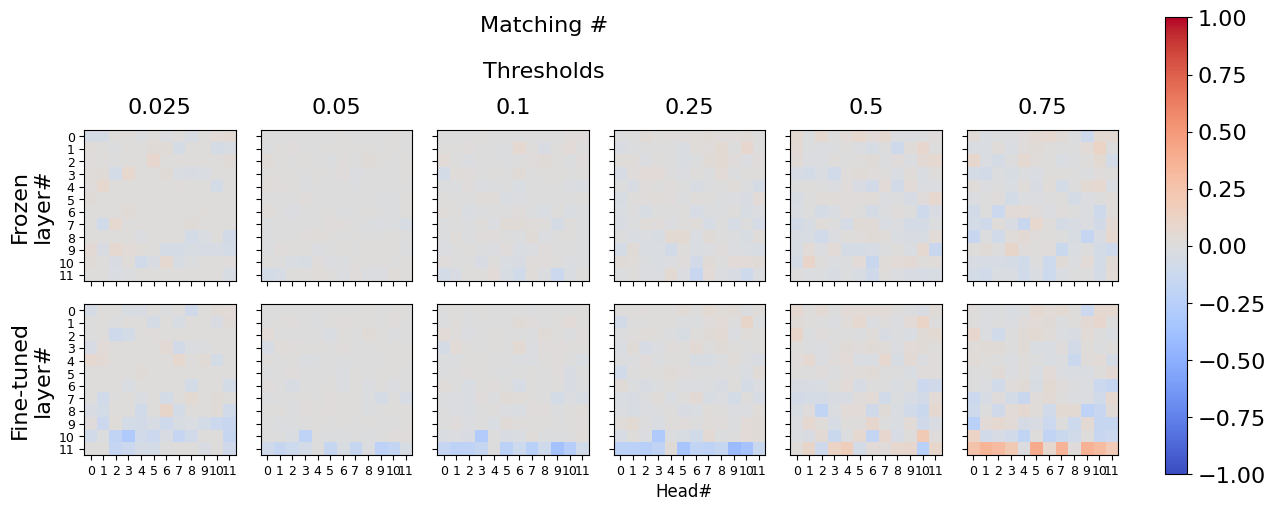

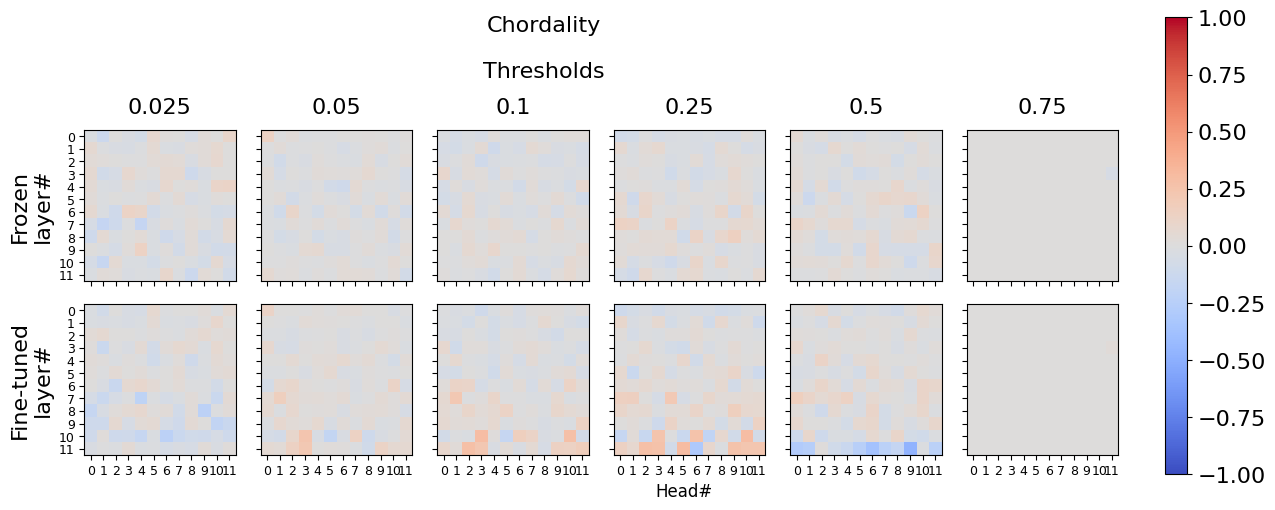

In [13]:
for f in topological_names:
    data, ths = make_comparison_data(matrices_tr, matrices_nt, f, names = topological_names, topological = True)
    draw_heatmaps_trained_nontrained(data,thresholds = topological_thresholds, title=topological_titles[f], )
    plt.show()

# Features distance

In [14]:
cola_gr_major=pd.read_csv("./data/en-cola/phenomenon_minor.tsv", sep='\t')
cola_gr_major = cola_gr_major[cola_gr_major['Sentence'].isin(df.sentence.values)]
cola_gr_major = cola_gr_major.reset_index(drop=True)

In [15]:
df=df.reset_index(drop=True)

In [16]:
all_data=dict()
arr=[] 
for features in ['Sem  Violation', "Infl/Agr Violation", 
                 "Extra/Mising Expr", "Correct", "Syntax", "All"]:
    inds=df[df['label']==1].index
    if features not in {"Correct", "Syntax", "All"}:
        inds=cola_gr_major[cola_gr_major[features]==1].index
        inds = [i for i in list(inds) if i in df[df['label']==0].index]
        arr.extend(list(inds))
    if features == "All":
        inds=df.index
    if features == "Syntax":
        syntax_ph = cola_gr_major.drop(arr) # Sentences with Syntax violations = rest sentences
        inds = syntax_ph[syntax_ph['Acceptability']==0].index
    features_class_imp=dict()
    distances_layers=[]
    for l in trange(0,topological_features_tr.shape[0]):
        distances_all=[]
        for h in range(0,topological_features_tr.shape[1]):
            table_1= topological_get_layer_head(topological_features_tr, l, h)
            table_1 = table_1[table_1.columns.drop(list(table_1.filter(regex='w_t')))]
            table_1=pd.concat([table_1, barcode_get_layer_head(barcode_features_tr, l, h)],axis=1)
            table_1=pd.concat([table_1, template_get_layer_head(template_features_tr, l, h)],axis=1)
            table_2=topological_get_layer_head(topological_features_nt, l, h)
            table_2 = table_2[table_2.columns.drop(list(table_2.filter(regex='w_t')))]
            table_2=pd.concat([table_2, barcode_get_layer_head(barcode_features_nt, l, h)],axis=1)
            table_2=pd.concat([table_2, template_get_layer_head(template_features_nt, l, h)],axis=1)
            distances=[]
            for feature in table_1.columns:
                a = table_1.loc[inds,feature].values
                if np.all(a == a[0]): # constant features
                    continue
                distance_i = distance.correlation(table_1.loc[inds,feature].values,table_2.loc[inds,feature].values)
                if not distance_i or np.isnan(distance_i) or np.isinf(distance_i):
                    distance_i=0
                distances.append(distance_i)
            distances=np.array(distances)
            distances_all.append(distances.mean())
        distances_all=np.array(distances_all)
        distances_layers.append(distances_all.mean())
    all_data[features]=distances_layers

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

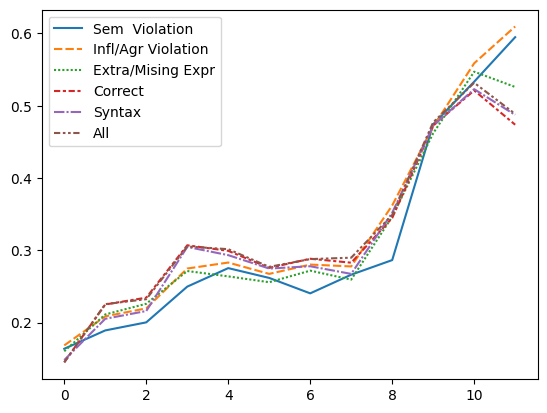

In [17]:
data_plot_dist=pd.DataFrame.from_dict(all_data)
sns.lineplot(data=data_plot_dist)
plt.show()

In [18]:
# In paper we plot distance between concatenated dev and test features